In [1]:
from dataloader import read_bci_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

train_data, train_label, test_data, test_label = read_bci_data()
Train = DataLoader(list(zip(train_data,train_label)),batch_size=64,shuffle=True)
Test = DataLoader(list(zip(test_data,test_label)),batch_size=64)




In [2]:
class EEGNet(nn.Module):
    def __init__(self, activation):
        super(EEGNet, self).__init__()
        #network architecture
        self.firstConv = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size = (1, 51), stride = (1,1), 
                padding = (0, 25), bias = False
            ), 
            nn.BatchNorm2d(
                16, eps=1e-05, momentum=0.1, affine=True, 
                track_running_stats=True
            )
        )
        
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(
                16, 32, kernel_size = (2, 1), stride = (1,1), 
                groups = 16, bias = False
            ), 
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, 
                track_running_stats=True
            ),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p = 0.25)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(
                32, 32, kernel_size = (1, 15), stride = (1,1), 
                padding = (0, 7), bias = False
            ), 
            nn.BatchNorm2d(
                32, eps=1e-05, momentum=0.1, affine=True, 
                track_running_stats=True
            ),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p = 0.25)
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=736,  out_features=2, bias=True)
        )
    
    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)

        #flatten
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x
    

In [3]:
class DeepConv(nn.Module):
    def __init__(self, activation, deepconv = [25, 50, 100, 200]):
        super(DeepConv, self).__init__()

        self.deepconv = deepconv
        self.conv0 = nn.Sequential(
            nn.Conv2d(
                1, deepconv[0], kernel_size=(1, 5)
            ),
            nn.Conv2d(
                deepconv[0], deepconv[0], kernel_size=(2, 1)
            ),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            activation(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )

        for idx in range(1, len(deepconv)):
            setattr(self, 'conv'+str(idx), nn.Sequential(
                nn.Conv2d(
                    deepconv[idx-1], deepconv[idx], kernel_size=(1, 5)
                ),
                nn.BatchNorm2d(deepconv[idx],eps=1e-05, momentum=0.1),
                activation(),
                nn.MaxPool2d(kernel_size=(1, 2)),
                nn.Dropout(p=0.5)
            ))
        
        self.classify = nn.Sequential(
            nn.Linear(8600, 2, bias=True)
        )
    def forward(self, x):
        # self.conv0(x)
        # self.conv1(x)
        # self.conv2(x)
        # self.conv3(x)

        for i in range(len(self.deepconv)):
            x = getattr(self, 'conv'+str(i))(x)

#         print('stage 1:', x.size())
        x = x.view(x.size(0), -1)
#         print('stage 2:', x.size())
        x = self.classify(x)
#         print('stage 3:', x.size())
        return x


In [4]:
def evaluate (net ,Data):
    count = 0
    for t,pair in enumerate(Data):
        data,label = pair
        data = data.float()
        label = label.long()
        data , label = data.cuda(),label.cuda()
        #foward
        output = net(data)        
        for i in range(len(label)):
            l = label[i].item()
            idx =torch.argmax(output[i])
            idx =idx.item()
            if(idx==l):count+=1
    accu = count/1080
    if(Data==Train):print("Train_accuracy = ",accu)
    if(Data==Test):print("Test_accuracy = ",accu)
    return accu


In [5]:
def validation(mode,activation,path):
    #choose the mode and activateion
    if(mode=="EEG"):net=EEGNet(activation).to(device)
    if(mode=="DeepConv"):net=DeepConv(activation).to(device)
    
    net.load_state_dict(torch.load(path))
#     net.eval()
    print("load",path)
    
    count = 0
    for t,pair in enumerate(Test):
        data,label = pair
        data = data.float()
        label = label.long()
        data , label = data.cuda(),label.cuda()
        #foward
        output = net(data)        
        for i in range(len(label)):
            l = label[i].item()
            idx =torch.argmax(output[i])
            idx =idx.item()
            if(idx==l):count+=1
    accu = count/1080
    print("Max_accuracy = ",accu)
    return accu

In [6]:
Max = 0
def run(mode,activation):
    global count
    global Max
    #choose the mode and activateion
    if(mode=="EEG"):net=EEGNet(activation).to(device)
    if(mode=="DeepConv"):net=DeepConv(activation).to(device)
    
    loss_list = []
    train_accu = []
    test_accu = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(),lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=0.9999)

    for epoch in range(epochs):
        #learning rate decay
        if(epoch>epochs/2):scheduler.step()
#         train_out = []
#         test_out =[]
        #using training data update weight     
        print("epoch:",epoch+1)
        tr_a = evaluate(net,Train)
        te_a = evaluate(net,Test)
        for i, pair in enumerate(Train):
            data,label = pair
            data = data.float()
            label = label.long()
            data , label = data.cuda(),label.cuda()
            
            # zero the parameter gradients 
            optimizer.zero_grad()

            #foward
            output = net(data)
#             train_out += output
            loss = criterion(output , label)
            #caculate gradient
            loss.backward()
            #using gradient update weight
            optimizer.step()
            loss_list.append(loss.item())

        #test accu of testing data
        for i, pair in enumerate(Test):
            data,label = pair
            data = data.float()
            label = label.long()
            data , label = data.cuda(),label.cuda()
            #foward
            output = net(data)
#             test_out += output

        # Validation accuracy
        train_accu.append(tr_a)
        test_accu.append(te_a)
        print("max_test_accu = ",max(test_accu))
        if(te_a==max(test_accu)):
            if(activation==nn.ELU):act="_ELU"
            if(activation==nn.LeakyReLU):act="_LeakyReLU"
            if(activation==nn.ReLU):act="_ReLU"
            torch.save(net.state_dict(), "CKPT/"+mode+act+'_final_ckpt')
        if(te_a==max(test_accu)):
            if(activation==nn.ELU):act="_ELU"
            if(activation==nn.LeakyReLU):act="_LeakyReLU"
            if(activation==nn.ReLU):act="_ReLU"
            torch.save(net.state_dict(), "CKPT/"+mode+act+'_final_ckpt')
    loss_list.append(loss.item())
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(loss_list)
    plt.show()
#     torch.save(net.state_dict(), "CKPT/"+flag[count])
    count += 1
    return train_accu,test_accu

In [7]:
def plotImg(cmd):
    if(cmd=="EEG"):
        relu_train,relu_test,leaky_relu_train,leaky_relu_test,elu_train,elu_test = (
        EEG_relu_train,EEG_relu_test,EEG_leaky_relu_train,EEG_leaky_relu_test,EEG_elu_train,EEG_elu_test)
    if(cmd=="DeepConv"):
        relu_test,relu_train,leaky_relu_train,leaky_relu_test,elu_train,elu_test = (
        DeepConv_relu_train,DeepConv_relu_test,DeepConv_leaky_relu_train,DeepConv_leaky_relu_test,DeepConv_elu_train,EEG_elu_test)
    plt.title = "test"
    plt.figure(figsize = (10, 5))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.plot(relu_test,color="blue",label="relu_test")
    plt.plot(relu_train,color="orange",label="relu_train")
    plt.plot(leaky_relu_train,color="green",label="leaky_relu_train")
    plt.plot(leaky_relu_test,color="red",label="leaky_relu_test")
    plt.plot(elu_train,color="purple",label="elu_train")
    plt.plot(elu_test,color="brown",label="elu_test")
    plt.legend()
    plt.show()

pytorch device:  cuda
epoch: 1
Train_accuracy =  0.4888888888888889
Test_accuracy =  0.49907407407407406
max_test_accu =  0.49907407407407406
epoch: 2
Train_accuracy =  0.7148148148148148
Test_accuracy =  0.7027777777777777
max_test_accu =  0.7027777777777777
epoch: 3
Train_accuracy =  0.7472222222222222
Test_accuracy =  0.7111111111111111
max_test_accu =  0.7111111111111111
epoch: 4
Train_accuracy =  0.7620370370370371
Test_accuracy =  0.712037037037037
max_test_accu =  0.712037037037037
epoch: 5
Train_accuracy =  0.7555555555555555
Test_accuracy =  0.7074074074074074
max_test_accu =  0.712037037037037
epoch: 6
Train_accuracy =  0.775
Test_accuracy =  0.7287037037037037
max_test_accu =  0.7287037037037037
epoch: 7
Train_accuracy =  0.7555555555555555
Test_accuracy =  0.7222222222222222
max_test_accu =  0.7287037037037037
epoch: 8
Train_accuracy =  0.7842592592592592
Test_accuracy =  0.7212962962962963
max_test_accu =  0.7287037037037037
epoch: 9
Train_accuracy =  0.8055555555555556
Te

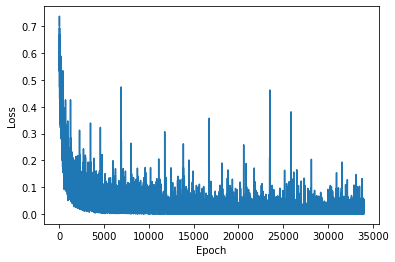

epoch: 1
Train_accuracy =  0.4898148148148148
Test_accuracy =  0.49537037037037035
max_test_accu =  0.49537037037037035
epoch: 2
Train_accuracy =  0.7231481481481481
Test_accuracy =  0.6990740740740741
max_test_accu =  0.6990740740740741
epoch: 3
Train_accuracy =  0.7435185185185185
Test_accuracy =  0.7268518518518519
max_test_accu =  0.7268518518518519
epoch: 4
Train_accuracy =  0.75
Test_accuracy =  0.7277777777777777
max_test_accu =  0.7277777777777777
epoch: 5
Train_accuracy =  0.7712962962962963
Test_accuracy =  0.7287037037037037
max_test_accu =  0.7287037037037037
epoch: 6
Train_accuracy =  0.774074074074074
Test_accuracy =  0.725
max_test_accu =  0.7287037037037037
epoch: 7
Train_accuracy =  0.7796296296296297
Test_accuracy =  0.7361111111111112
max_test_accu =  0.7361111111111112
epoch: 8
Train_accuracy =  0.8027777777777778
Test_accuracy =  0.7416666666666667
max_test_accu =  0.7416666666666667
epoch: 9
Train_accuracy =  0.8027777777777778
Test_accuracy =  0.7481481481481481


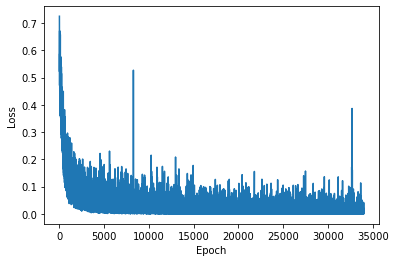

epoch: 1
Train_accuracy =  0.46574074074074073
Test_accuracy =  0.49074074074074076
max_test_accu =  0.49074074074074076
epoch: 2
Train_accuracy =  0.7287037037037037
Test_accuracy =  0.7083333333333334
max_test_accu =  0.7083333333333334
epoch: 3
Train_accuracy =  0.7527777777777778
Test_accuracy =  0.7
max_test_accu =  0.7083333333333334
epoch: 4
Train_accuracy =  0.7759259259259259
Test_accuracy =  0.7240740740740741
max_test_accu =  0.7240740740740741
epoch: 5
Train_accuracy =  0.7768518518518519
Test_accuracy =  0.7138888888888889
max_test_accu =  0.7240740740740741
epoch: 6
Train_accuracy =  0.7611111111111111
Test_accuracy =  0.7277777777777777
max_test_accu =  0.7277777777777777
epoch: 7
Train_accuracy =  0.7814814814814814
Test_accuracy =  0.7324074074074074
max_test_accu =  0.7324074074074074
epoch: 8
Train_accuracy =  0.7925925925925926
Test_accuracy =  0.7342592592592593
max_test_accu =  0.7342592592592593
epoch: 9
Train_accuracy =  0.7935185185185185
Test_accuracy =  0.737

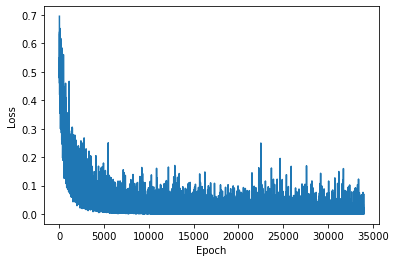

epoch: 1
Train_accuracy =  0.47962962962962963
Test_accuracy =  0.487962962962963
max_test_accu =  0.487962962962963
epoch: 2
Train_accuracy =  0.5953703703703703
Test_accuracy =  0.6092592592592593
max_test_accu =  0.6092592592592593
epoch: 3
Train_accuracy =  0.6111111111111112
Test_accuracy =  0.5722222222222222
max_test_accu =  0.6092592592592593
epoch: 4
Train_accuracy =  0.6833333333333333
Test_accuracy =  0.6462962962962963
max_test_accu =  0.6462962962962963
epoch: 5
Train_accuracy =  0.6796296296296296
Test_accuracy =  0.6638888888888889
max_test_accu =  0.6638888888888889
epoch: 6
Train_accuracy =  0.7157407407407408
Test_accuracy =  0.7018518518518518
max_test_accu =  0.7018518518518518
epoch: 7
Train_accuracy =  0.7472222222222222
Test_accuracy =  0.7287037037037037
max_test_accu =  0.7287037037037037
epoch: 8
Train_accuracy =  0.7611111111111111
Test_accuracy =  0.7055555555555556
max_test_accu =  0.7287037037037037
epoch: 9
Train_accuracy =  0.7166666666666667
Test_accura

In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('pytorch device: ', device)
    #EEGNet
    flag = ["EEG_ReLU","EEG_LeakReLU","EEG_ELU","DeepConv_ReLU","DeepConv_LeakyReLU","DeepConv_ELU"]
    count=0
    train=1
    epochs = 2000
    if(train==1):
        EEG_leaky_relu_train,EEG_leaky_relu_test = run("EEG",nn.LeakyReLU)
        EEG_relu_train,EEG_relu_test = run("EEG",nn.ReLU)
        EEG_elu_train,EEG_elu_test = run("EEG",nn.ELU)
        EEG_Max_leaky_relu  = max(EEG_leaky_relu_test)
        EEG_Max_relu  = max(EEG_relu_test)
        EEG_Max_elu  = max(EEG_elu_test)

        #DeepConv
        DeepConv_leaky_relu_train,DeepConv_leaky_relu_test = run("DeepConv",nn.LeakyReLU)
        DeepConv_relu_train,DeepConv_relu_test = run("DeepConv",nn.ReLU)
        DeepConv_elu_train,DeepConv_elu_test = run("DeepConv",nn.ELU)
        DeepConv_Max_leaky_relu  = max(DeepConv_leaky_relu_test)
        DeepConv_Max_relu  = max(DeepConv_relu_test)
        DeepConv_Max_elu  = max(DeepConv_elu_test)

        plotImg("EEG")
        plotImg("DeepConv")

        fp = open("Record_original.txt", "a")
        fp.write("EEG_Max_leaky_relu = " )
        fp.write(str(EEG_Max_leaky_relu))
        fp.write(", EEG_Max_relu = ")
        fp.write(str(EEG_Max_relu))
        fp.write(", EEG_Max_elu = ")
        fp.write(str(EEG_Max_elu))
        fp.write("\n")        
        fp.write("DeepConv_Max_leaky_relu = " )
        fp.write(str(DeepConv_Max_leaky_relu))
        fp.write(", DeepConv_Max_relu = ")
        fp.write(str(DeepConv_Max_relu))
        fp.write(", DeepConv_Max_elu = ")
        fp.write(str(DeepConv_Max_elu))
        fp.write("\n")
        fp.close()

        print("EEG_Max_leaky_relu = " ,EEG_Max_leaky_relu)
        print("EEG_Max_relu = " ,EEG_Max_relu)
        print("EEG_Max_elu = " ,EEG_Max_elu)
        print("DeepConv_Max_leaky_relu = " ,DeepConv_Max_leaky_relu)
        print("DeepConv_Max_relu = " ,DeepConv_Max_relu)
        print("DeepConv_Max_elu = " ,DeepConv_Max_elu)
    else:
        #validation
        ckpt = "CKPT/"+"EEG_ReLU_final_ckpt"
        validation("EEG",nn.ReLU,ckpt)
        ckpt = "CKPT/"+"EEG_LeakyReLU_final_ckpt"
        validation("EEG",nn.LeakyReLU,ckpt)
        ckpt = "CKPT/"+"EEG_ELU_final_ckpt"
        validation("EEG",nn.ELU,ckpt)
        
        ckpt = "CKPT/"+"DeepConv_ReLU_final_ckpt"
        validation("DeepConv",nn.ReLU,ckpt)
        ckpt = "CKPT/"+"DeepConv_LeakyReLU_final_ckpt"
        validation("DeepConv",nn.LeakyReLU,ckpt)
        ckpt = "CKPT/"+"DeepConv_ReLU_final_ckpt"

        validation("DeepConv",nn.ELU,ckpt)

